In [1]:
import time
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
%cd /Users/tim/MMT/wfsdat/binospec/2017.1113

foc_trans = 40.8 * u.nm / u.um
cc_trans = 24.97 * u.um / u.arcsec

/Users/tim/MMT/wfsdat/binospec/2017.1113


In [2]:
%load_ext autoreload
%autoreload 2

### Set up the nominal baselines

In [3]:
# first set
baseline_1 = [
    "wfs_ff_cal_img_2017.1113.111402.fits",
    "wfs_ff_cal_img_2017.1113.111425.fits",
    "wfs_ff_cal_img_2017.1113.111448.fits"
]

# second set
baseline_2 = [
    "wfs_ff_cal_img_2017.1113.112547.fits",
    "wfs_ff_cal_img_2017.1113.112610.fits",
    "wfs_ff_cal_img_2017.1113.112634.fits",
    "wfs_ff_cal_img_2017.1113.112657.fits"
]

b1_zerns = []
b2_zerns = []
for f in baseline_1:
    zfile = f"{f}.rot.zernikes"
    b1_zerns.append(ZernikeVector(coeffs=zfile))
for f in baseline_2:
    zfile = f"{f}.rot.zernikes"
    b2_zerns.append(ZernikeVector(coeffs=zfile))

# calculate the averages
b1_ave = ZernikeVector()
b2_ave = ZernikeVector()
for z in b1_zerns:
    b1_ave += z
b1_ave /= len(b1_zerns)

for z in b2_zerns:
    b2_ave += z
b2_ave /= len(b2_zerns)

#### Inspect differences between first baseline and average of first 3

Fringe Coefficients
 Z02:       181 nm 	 X Tilt (1, 1)
 Z03:      -209 nm 	 Y Tilt (1, -1)
 Z04:     -16.7 nm 	 Defocus (2, 0)
 Z05:       248 nm 	 Primary Astig at 45° (2, -2)
 Z06:      8.82 nm 	 Primary Astig at 0° (2, 2)
 Z07:      65.4 nm 	 Primary Y Coma (3, -1)
 Z08:     -11.9 nm 	 Primary X Coma (3, 1)
 Z09:     -6.83 nm 	 Y Trefoil (3, -3)
 Z10:      55.4 nm 	 X Trefoil (3, 3)
 Z11:     -4.41 nm 	 Primary Spherical (4, 0)
 Z12:     -51.7 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:     -79.2 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:     -14.2 nm 	 X Tetrafoil (4, 4)
 Z15:     -66.7 nm 	 Y Tetrafoil (4, -4)
 Z16:     -66.6 nm 	 Secondary X Coma (5, 1)
 Z17:     -15.6 nm 	 Secondary Y Coma (5, -1)
 Z18:     -41.2 nm 	 Secondary X Trefoil (5, 3)
 Z19:     -36.9 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      10.8 nm 	 X Pentafoil (5, 5)
 Z21:     -51.1 nm 	 Y Pentafoil (5, -5)
 Z22:     -7.36 nm 	 Secondary Spherical (6, 0)
 Z23:        18 nm 	 Tertiary Astigmatism at 45° (6, 

<IPython.core.display.Javascript object>


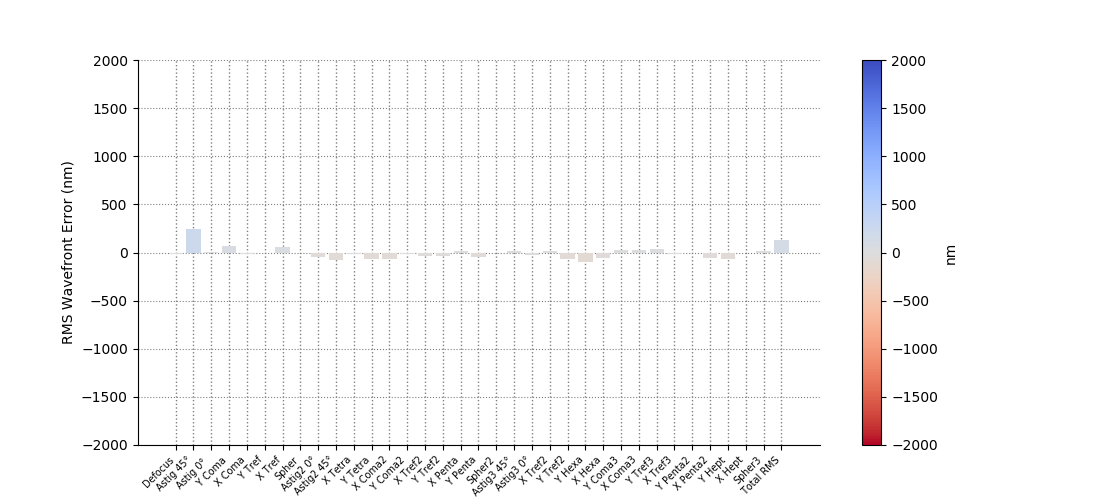

In [4]:
sub = b1_zerns[0] - b1_ave
print(sub)
sub.fringe_bar_chart().show()

Looks like there's some variation. Let's calculate the RMS scatter of the baseline measurements.

In [5]:
b1_rms = ZernikeVector()
for z in b1_zerns:
    b1_rms += (z - b1_ave)**2
b1_rms = b1_rms**0.5

b2_rms = ZernikeVector()
for z in b2_zerns:
    b2_rms += (z - b2_ave)**2
b2_rms = b1_rms**0.5

<IPython.core.display.Javascript object>


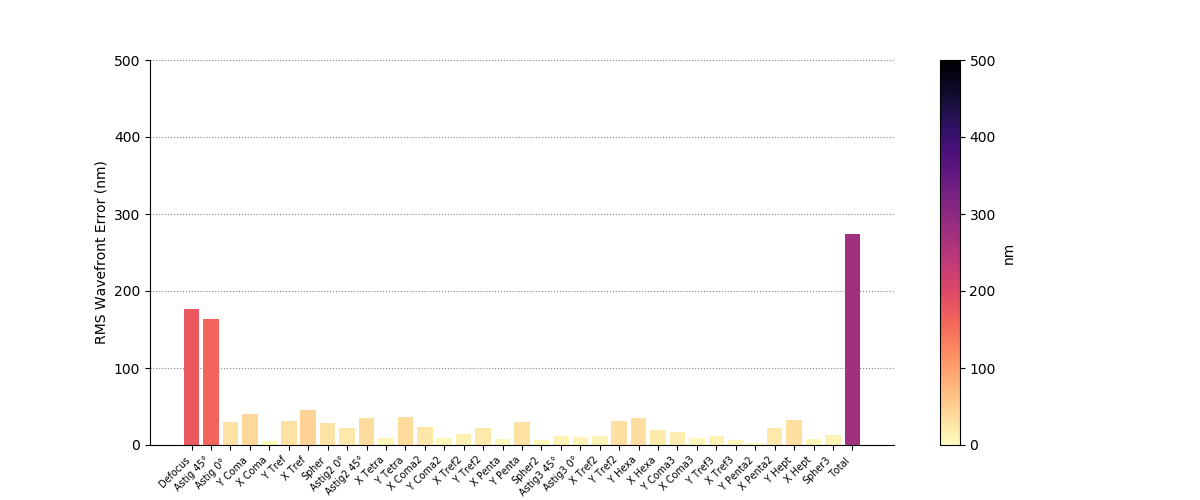

In [6]:
b1_rms.bar_chart().show()

<IPython.core.display.Javascript object>


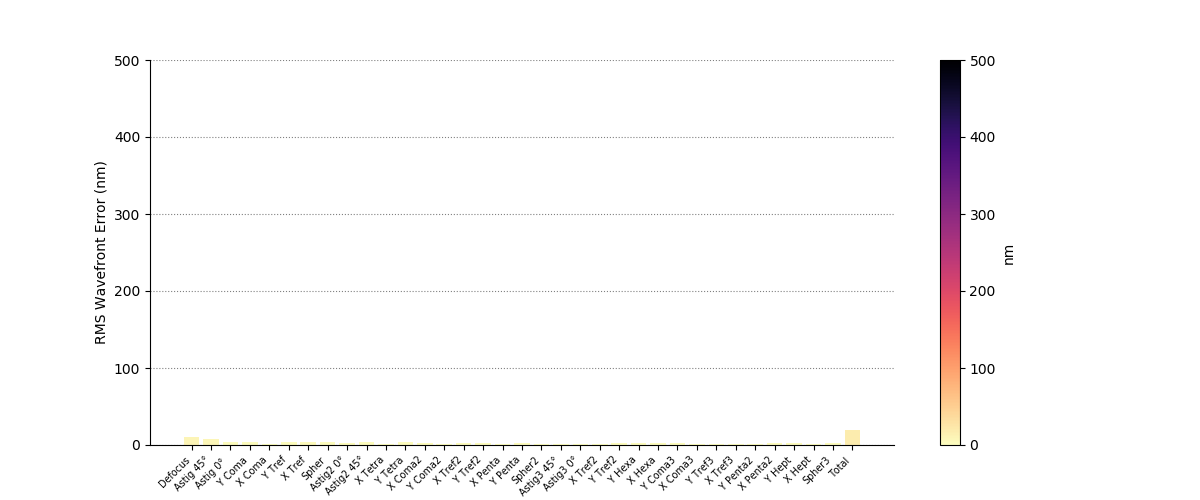

In [7]:
b2_rms.bar_chart().show()

### The second set of nominal values have way less scatter than the first set!

In [8]:
print(f"Set 1 focus RMS: {b1_rms['Z04'] / foc_trans}, Set 2 focus RMS: {b2_rms['Z04'] / foc_trans}")

Set 1 focus RMS: 7.499294442699814 um, Set 2 focus RMS: 0.42872629536883056 um


#### Inspect the difference between the averages of the two sets of baselines

Some clear drift in some terms, especially defocus and astig 45.  These could be due to changes in temperature, especially in the primary.  However, there's variation just within the first three so it could also be changes due to seeing.  

<IPython.core.display.Javascript object>


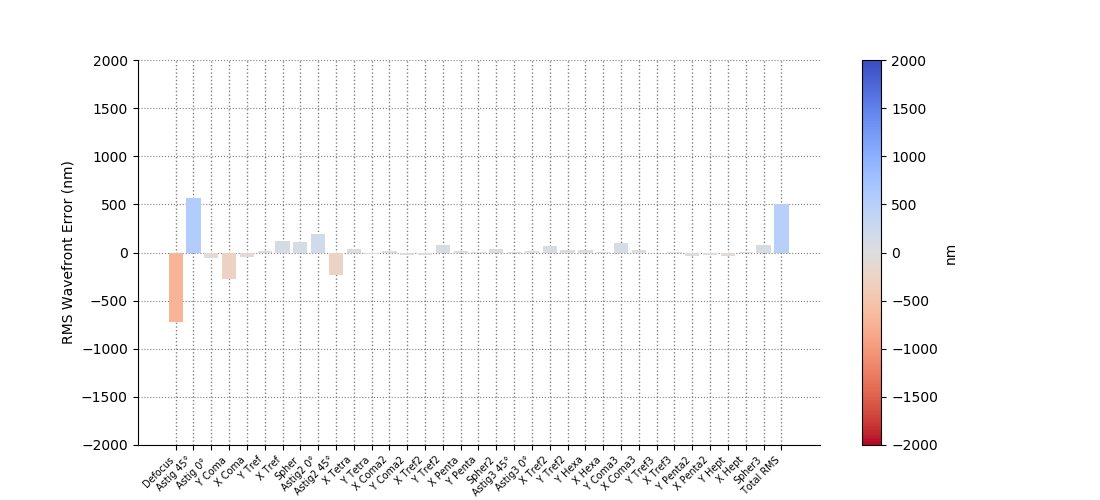

<Quantity -17.591873711273546 um>

In [9]:
b1_sub =  b2_ave - b1_ave
b1_sub.fringe_bar_chart().show()
b1_sub['Z04'] / foc_trans

### Check the focus dithers

In [10]:
foc_nominal = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.110503.fits.rot.zernikes")

<IPython.core.display.Javascript object>


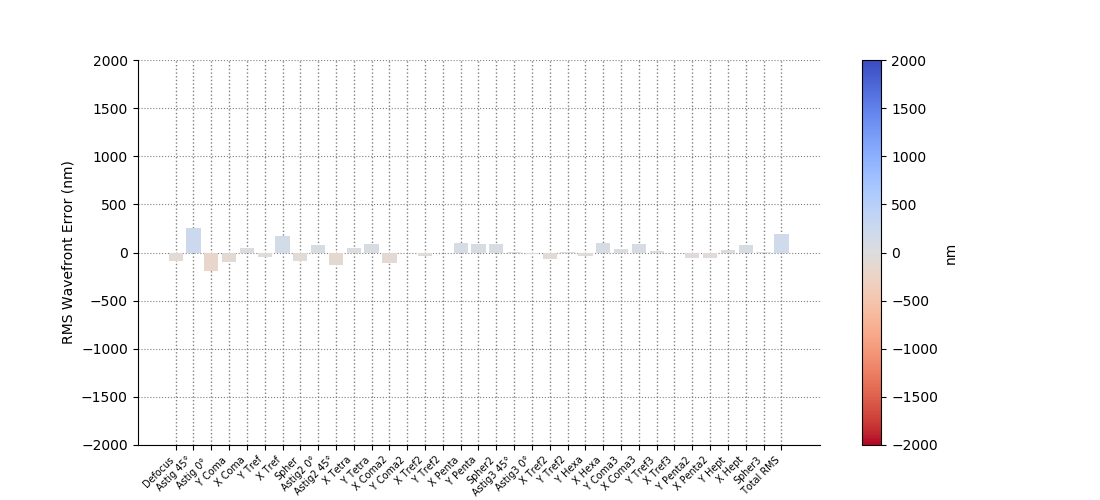

In [15]:
foc1 = foc_nominal - b1_ave
foc1.fringe_bar_chart().show()

In [16]:
foc_p100 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.110550.fits.rot.zernikes") - foc_nominal
foc_m100 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.110700.fits.rot.zernikes") - foc_nominal
foc_m50 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.110724.fits.rot.zernikes") - foc_nominal
foc_p50 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.110810.fits.rot.zernikes") - foc_nominal

In [17]:
foc_p100['Z04'] / foc_trans

<Quantity 103.00649066153623 um>

In [18]:
foc_m100['Z04'] / foc_trans

<Quantity -61.61273228091272 um>

In [19]:
foc_m50['Z04'] / foc_trans

<Quantity -43.608593759832 um>

In [20]:
foc_p50['Z04'] / foc_trans

<Quantity 61.813326581343574 um>

<IPython.core.display.Javascript object>


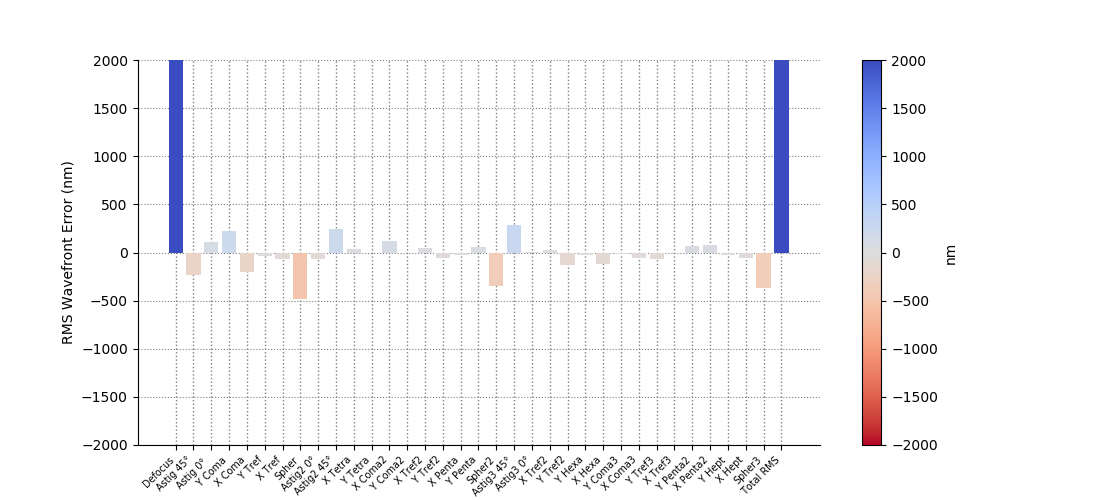

In [26]:
foc_p100.fringe_bar_chart().show()

Looks like large focus changes also result in increases in the other spherical terms...

In [28]:
astig0_p500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.111559.fits.rot.zernikes") - b2_ave
astig0_m500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.111709.fits.rot.zernikes") - b2_ave
astig0_m1000 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.111843.fits.rot.zernikes") - b2_ave
astig0_p1000 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.111954.fits.rot.zernikes") - b2_ave
astig45_p500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.112104.fits.rot.zernikes") - b2_ave
astig45_p1000 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.112215.fits.rot.zernikes") - b2_ave
astig45_m500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.112350.fits.rot.zernikes") - b2_ave
astig45_m1000 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.112500.fits.rot.zernikes") - b2_ave
trefx_p500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.112807.fits.rot.zernikes") - b2_ave
trefx_m500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.112854.fits.rot.zernikes") - b2_ave
trefy_p500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.113004.fits.rot.zernikes") - b2_ave
trefy_m500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.113051.fits.rot.zernikes") - b2_ave
spher_p500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.113201.fits.rot.zernikes") - b2_ave
spher_m500 = ZernikeVector(coeffs="wfs_ff_cal_img_2017.1113.113311.fits.rot.zernikes") - b2_ave

In [39]:
astig45_p500['Z05']

<Quantity -1093.5316618299364 nm>

In [43]:
trefy_p500

Fringe Coefficients
 Z02:       114 nm 	 X Tilt (1, 1)
 Z03:      84.4 nm 	 Y Tilt (1, -1)
 Z04:      -441 nm 	 Defocus (2, 0)
 Z05:     -98.1 nm 	 Primary Astig at 45° (2, -2)
 Z06:       144 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -147 nm 	 Primary Y Coma (3, -1)
 Z08:      -110 nm 	 Primary X Coma (3, 1)
 Z09:      -130 nm 	 Y Trefoil (3, -3)
 Z10:      -507 nm 	 X Trefoil (3, 3)
 Z11:      47.9 nm 	 Primary Spherical (4, 0)
 Z12:     -62.7 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:     -24.8 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:      29.5 nm 	 X Tetrafoil (4, 4)
 Z15:     -84.1 nm 	 Y Tetrafoil (4, -4)
 Z16:    -0.107 nm 	 Secondary X Coma (5, 1)
 Z17:       105 nm 	 Secondary Y Coma (5, -1)
 Z18:     -27.2 nm 	 Secondary X Trefoil (5, 3)
 Z19:     -18.8 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      36.1 nm 	 X Pentafoil (5, 5)
 Z21:      -142 nm 	 Y Pentafoil (5, -5)
 Z22:     -19.4 nm 	 Secondary Spherical (6, 0)
 Z23:      15.7 nm 	 Tertiary Astigmatism at 45° (6, 

In [46]:
spher_p500['Z11']

<Quantity 725.6720431797933 nm>